In [1]:
import padasip as pa
import numpy as np
import os
import librosa
from mir_eval.separation import bss_eval_sources
import scipy.io.wavfile as wavfile

In [34]:
import pandas as pd

# Metrics before ANC use

In [26]:
def signaltonoise(a, axis, ddof): 
    a = np.asanyarray(a) 
    m = a.mean(axis) 
    sd = a.std(axis = axis, ddof = ddof) 
    return round(float(np.where(sd == 0, 0, m / sd)),4)

In [83]:
history_metrics = []
for folder in os.listdir(os.path.join(os.getcwd(),"visualization")):
    if(os.path.isdir(os.path.join(os.getcwd(),"visualization",folder))):
        fold_path = os.path.join(os.getcwd(),"visualization",folder)
        #required gt1.wav, gt2.wav, pred1.wav, pred2.wav
        gt1,sr = librosa.load(os.path.join(fold_path,'gt1.wav'), mono=True)   
        gt2,sr = librosa.load(os.path.join(fold_path,'gt2.wav'), mono=True)   
        pred1,sr = librosa.load(os.path.join(fold_path,'pred1.wav'), mono=True)   
        pred2,sr = librosa.load(os.path.join(fold_path,'pred2.wav'), mono=True)   
        mix_wav, sr = librosa.load(os.path.join(fold_path, 'mix.wav'), mono=True)
        L = len(gt1)
        #check the output sir, sar, sdr
        gts_wav = [gt1, gt2]
        preds_wav = [pred1, pred2]
        valid = True
        for n in range(0,2):
            valid *= np.sum(np.abs(gts_wav[n])) > 1e-5
            valid *= np.sum(np.abs(preds_wav[n])) > 1e-5
        if valid:
            sdr, sir, sar, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray(preds_wav),
                False)
            sdr_mix, _, _, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray([mix_wav[0:L] for n in range(2)]),
                False)
            #formula for calculation of MSE, then take mean of 2
            MSE_baseline = np.array([np.dot(gt2-pred2, gt2-pred2) / float(len(gt2)), np.dot(gt1-pred1, gt1-pred1) / float(len(gt1))])
            #formula for calculation of SNR using scipy and take mean of 2
            snr = np.array([signaltonoise(pred1, axis = 0, ddof = 0),signaltonoise(pred2, axis = 0, ddof = 0)])

            history_metrics.append([sdr_mix.mean(),sdr.mean(),sir.mean(),sar.mean(), snr.mean(), MSE_baseline.mean()])

In [84]:
df = pd.DataFrame(np.array(history_metrics),columns = ['sdr_mix', 'sdr', 'sir', 'sar', 'snr', 'mse'])

In [85]:
df.head()

,sdr_mix,sdr,sir,sar,snr,mse
0,1.121710,6.965341,16.238405,7.722375,0.00005,0.000665
1,2.089944,1.945236,2.355123,14.474421,0.00085,0.010242
2,0.824252,12.778002,22.406092,16.225929,-0.00005,0.000283
3,0.478323,15.451141,24.541708,16.189062,-0.00010,0.000528
4,0.424398,0.799295,2.273107,19.142831,0.00000,0.008431


In [86]:
df.to_csv("Baseline_model_results.csv")

In [87]:
sdr_mix, sdr, sir, sar, snr, mse_baseline = np.mean(history_metrics, axis = 0) #mean over all data items
print('before applying ANC: ',sdr_mix, sdr, sir,sar, snr, mse_baseline)

before applying ANC:  0.9138982897144425 6.746662417807138 11.995709497175506 11.46497063986228 0.00038974358974358975 0.001980759435398397


# Metrics after ANC used


* Table for 2 audios with different lr and weights filter size
* table for final metrics on whole dataset using the parameters selected above
* box plot of metrics on complete dataset using parameters selected above
----------------
* Version 1: iterations = 10000, lr = 0.01 was used which is saved with names `pred1_anc.wav`
* Version 1: iterations = 50000, lr = 0.0001 was used which is saved with names `pred1_anc50000.wav` 

In [39]:
def adaptive_noice_cancellation(filter_type, input_with_noise, noise, length_of_signal, m, learning_rate):
    """
    Adaptive noice cancellation using adaptive filtering
    
    Parameters:
    m = number of taps or filter size
    learning_rate = decides change in the weigths per iteration
    
    Results:
    filtered_signal: the output of ANC
    hist_lmserror = list of lms error for each iteration
    
    """
    #initialization
    input_with_noise = np.asarray(input_with_noise)         #input to adaptive noise cancellation filter
    noise = np.asarray(noise)       #input to adaptive filter
    weights = np.zeros(shape = m )
    mu = 1 - learning_rate
    eps = 0.5
    noise_estimate = np.zeros(shape = length_of_signal)
    filtered_signal = input_with_noise.copy()
    
    R = 1/eps*np.identity(m)
    
    hist_lmserror = []
    hist_sample_error = []
    #loop till we reach sufficient minimized filtered signal or error
    for i in range(m-1, length_of_signal):
        noise_sample = noise[i-m+1:i+1]
        assert noise_sample.shape == weights.shape , "shape of noise_sample and weights should be same"
        noise_estimate[i] = np.dot(noise_sample,weights)
        filtered_signal[i] = input_with_noise[i] - noise_estimate[i]
        error = filtered_signal[i]
        
        if(filter_type == 'lms'):
            #lms weights' adaptation step
            weights = weights + 2*learning_rate*error*noise_sample       #u*error*input_to_filter
        elif(filter_type == 'rls'):
            #rls weights' adaptation step
            R1 = np.dot(np.dot(np.dot(R,noise_sample),noise_sample.T),R)
            R2 = mu + np.dot(np.dot(noise_sample,R),noise_sample.T)
            R = 1/mu * (R - R1/R2)
            dw = np.dot(R, noise_sample.T) * error
            weights = weights + dw
        else:
            print('invalid filter argument')
            return [0],[0]
        #error history
        lms_error = np.sum(filtered_signal**2) / len(filtered_signal)
        hist_lmserror.append(lms_error)
        hist_sample_error.append(error)
    return filtered_signal, hist_lmserror

# Taking a sample of 3 mixed signals to determine optimum parameters for ANC

### Random sampling of mixed signals

In [40]:
target_path = os.path.join(os.getcwd(), 'visualization')
count = 0
sample = []
i = np.random.randint(0,40, 3)
k = 0
for folder in os.listdir(target_path):
    if(os.path.isdir(os.path.join(target_path,folder))):
        #print(folder)
        if(k in i):
            sample.append(folder)
        k += 1

In [41]:
print(sample)

['accordion-XZ1rUpbdu-Y+tuba-G46O0IzYtt0', 'cello-I0LedcEaPL0+tuba-P_lSgczU2Sk', 'flute-YR6kjiPyNHU+tuba-GV2bbRPFhvk']


In [42]:
learning_rate = np.logspace(-1, -5, num = 5)
m = np.array([4,16,64,128])
filter_type = ['rls', 'lms']

# change here

In [43]:
# TAKE ANY 1 FOLDER AND APPLY SNR FORMULA ON IT WITH LMS
# AND WITH RLS FILTER TO FILL THE COLUMN IN REPORT APPENDIX PARAMETER
# SELECTION

#run same code as below
#just put sample = ['accordion-XZ1rUpbdu-Y+tuba-G46O0IzYtt0'] manually
sample = ['accordion-XZ1rUpbdu-Y+tuba-G46O0IzYtt0']

In [44]:
history_metrics = []

for folder in sample:
        for f in filter_type:
            for taps in m:
                for lr in learning_rate:
                    fold_path = os.path.join(os.getcwd(),"visualization",folder)
                    #required gt1.wav, gt2.wav, pred1.wav, pred2.wav
                    gt1,sr = librosa.load(os.path.join(fold_path,'gt1.wav'), mono=True)   
                    gt2,sr = librosa.load(os.path.join(fold_path,'gt2.wav'), mono=True)   
                    pred1,sr = librosa.load(os.path.join(fold_path,'pred1.wav'), mono=True)   
                    pred2,sr = librosa.load(os.path.join(fold_path,'pred2.wav'), mono=True)   
                    mix_wav, sr = librosa.load(os.path.join(fold_path, 'mix.wav'), mono=True)
                    L = len(gt1)
                    #apply adaptive noice cancellation to pred1 and pred2
                    pred1_anc, lms_error = adaptive_noice_cancellation(f, pred1, pred2, L, taps, lr)
                    pred2_anc, lms_error = adaptive_noice_cancellation(f, pred2, pred1, L, taps, lr)
                    if(f=='rls'):
                        name1 = 'pred1_ancRLS.wav'
                        name2 = 'pred2_ancRLS.wav'
                    elif(f=='lms'):
                        name1 = 'pred1_ancLMS.wav'
                        name2 = 'pred2_ancLMS.wav'
                    wavfile.write(os.path.join(fold_path, name1),sr,pred1_anc)
                    wavfile.write(os.path.join(fold_path, name2),sr,pred2_anc)
                    #check the output sir, sar, sdr, mse
                    gts_wav = [gt1, gt2]
                    preds_wav = [pred1_anc, pred2_anc]
                    valid = True
                    for n in range(0,2):
                        valid *= np.sum(np.abs(gts_wav[n])) > 1e-5
                        valid *= np.sum(np.abs(preds_wav[n])) > 1e-5
                    if valid:
                        sdr, sir, sar, _ = bss_eval_sources(
                            np.asarray(gts_wav),
                            np.asarray(preds_wav),
                            False)
                        sdr_mix, _, _, _ = bss_eval_sources(
                            np.asarray(gts_wav),
                            np.asarray([mix_wav[0:L] for n in range(2)]),
                            False)
                        MSE_anc = np.array([np.dot(gt1 - pred1_anc, gt1-pred1_anc) / float(len(gt1)), np.dot(gt2 - pred2_anc, gt2-pred2_anc) / float(len(gt2))])
                        snr = np.array([signaltonoise(pred1_anc, axis = 0, ddof = 0),signaltonoise(pred2_anc, axis = 0, ddof = 0)])
                        history_metrics.append([f, taps, lr, sdr_mix.mean(),sdr.mean(),sir.mean(),sar.mean(), snr.mean(), MSE_anc.mean()])
                        print(f, taps, lr, 'done')

rls 4 0.1 done
rls 4 0.01 done
rls 4 0.001 done
rls 4 0.0001 done
rls 4 1e-05 done
rls 16 0.1 done
rls 16 0.01 done
rls 16 0.001 done
rls 16 0.0001 done
rls 16 1e-05 done
rls 64 0.1 done
rls 64 0.01 done
rls 64 0.001 done
rls 64 0.0001 done
rls 64 1e-05 done
rls 128 0.1 done
rls 128 0.01 done
rls 128 0.001 done
rls 128 0.0001 done
rls 128 1e-05 done
lms 4 0.1 done
lms 4 0.01 done
lms 4 0.001 done
lms 4 0.0001 done
lms 4 1e-05 done
lms 16 0.1 done
lms 16 0.01 done
lms 16 0.001 done
lms 16 0.0001 done
lms 16 1e-05 done
lms 64 0.1 done
lms 64 0.01 done
lms 64 0.001 done
lms 64 0.0001 done
lms 64 1e-05 done
lms 128 0.1 done
lms 128 0.01 done
lms 128 0.001 done
lms 128 0.0001 done
lms 128 1e-05 done


In [48]:
snr_learning = pd.DataFrame(history_metrics, columns = ['filter', 'size', 'lr', 'sdr_mix', 'sdr', 'sir', 'sar', 'snr', 'MSE ANC'])
display(snr_learning)
snr_learning.to_csv('snrSelection.csv')

,filter,size,lr,sdr_mix,sdr,sir,sar,snr,MSE ANC
0,rls,4,0.10000,0.495348,6.770158,23.532641,6.920361,-0.00085,0.000863
1,rls,4,0.01000,0.495348,13.611070,23.303047,14.173705,-0.00090,0.000149
2,rls,4,0.00100,0.495348,15.698184,24.251776,16.381699,-0.00015,0.000091
3,rls,4,0.00010,0.495348,15.825614,24.248776,16.534984,-0.00010,0.000087
4,rls,4,0.00001,0.495348,15.818741,24.184163,16.542678,-0.00010,0.000087
5,rls,16,0.10000,0.495348,6.849746,22.785814,7.075731,-0.00655,0.000981
6,rls,16,0.01000,0.495348,14.028287,22.041252,14.909545,-0.00190,0.000133
7,rls,16,0.00100,0.495348,15.580241,23.740153,16.329941,-0.00020,0.000093
8,rls,16,0.00010,0.495348,15.735294,24.020480,16.464680,-0.00010,0.000089
9,rls,16,0.00001,0.495348,15.781723,24.081970,16.508271,-0.00010,0.000088


In [ ]:
explore_learning = pd.DataFrame(history_metrics, columns = ['filter', 'size', 'lr', 'sdr_mix', 'sdr', 'sir', 'sar', 'snr', 'MSE ANC'])
display(explore_learning)
explore_learning.to_csv('parameterSelection.csv')

In [190]:
overall_performance = explore_learning.groupby(['filter', 'size', 'lr']).mean()

In [273]:
lms_performance = overall_performance.loc['lms'].copy()

rls_performance = overall_performance.loc['rls'].copy()

rls_performance.to_csv("rls_parameter.csv")

lms_performance.to_csv("lms_parameter.csv")

# by observation size = 128, lr = 0.00001 are the best parameter for rls

In [ ]:
rls_performance.loc[128, 0.00001]

# by observation size = 128, lr = 0.0001 are the best parameters for lms filter

sdr_mix          0.625400
sdr             11.614678
sir             18.543579
sar             13.336323
MSE baseline     0.000108
MSE ANC          0.000107
Name: (128, 0.0001), dtype: float64

In [ ]:
lms_performance.loc[128, 0.0001]

# Applying the optimal lms on complete dataset

In [49]:
history_metrics = []
for folder in os.listdir(os.path.join(os.getcwd(),"visualization")):
    if(os.path.isdir(os.path.join(os.getcwd(),"visualization",folder))):
        fold_path = os.path.join(os.getcwd(),"visualization",folder)
        #required gt1.wav, gt2.wav, pred1.wav, pred2.wav
        gt1,sr = librosa.load(os.path.join(fold_path,'gt1.wav'), mono=True)   
        gt2,sr = librosa.load(os.path.join(fold_path,'gt2.wav'), mono=True)   
        pred1,sr = librosa.load(os.path.join(fold_path,'pred1.wav'), mono=True)   
        pred2,sr = librosa.load(os.path.join(fold_path,'pred2.wav'), mono=True)   
        mix_wav, sr = librosa.load(os.path.join(fold_path, 'mix.wav'), mono=True)
        L = len(gt1)
        #apply adaptive noice cancellation to pred1 and pred2
        pred1_anc, lms_error1 = adaptive_noice_cancellation('lms', pred1, pred2, L, m = 128, learning_rate = 0.0001)
        pred2_anc, lms_error2 = adaptive_noice_cancellation('lms', pred2, pred1, L, m = 128, learning_rate = 0.0001)
        wavfile.write(os.path.join(fold_path, 'pred1_ancLMS.wav'),sr,pred1_anc)
        wavfile.write(os.path.join(fold_path, 'pred2_ancLMS.wav'),sr,pred2_anc)
        #check the output sir, sar, sdr
        gts_wav = [gt1, gt2]
        preds_wav = [pred1_anc, pred2_anc]
        valid = True
        for n in range(0,2):
            valid *= np.sum(np.abs(gts_wav[n])) > 1e-5
            valid *= np.sum(np.abs(preds_wav[n])) > 1e-5
        if valid:
            sdr, sir, sar, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray(preds_wav),
                False)
            sdr_mix, _, _, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray([mix_wav[0:L] for n in range(2)]),
                False)
            MSE_anc = np.array([np.dot(gt1 - pred1_anc, gt1-pred1_anc) / float(len(gt1)), np.dot(gt2 - pred2_anc, gt2-pred2_anc) / float(len(gt2))])
            snr = np.array([signaltonoise(pred1_anc, axis = 0, ddof = 0),signaltonoise(pred2_anc, axis = 0, ddof = 0)])
            history_metrics.append([sdr_mix.mean(),sdr.mean(),sir.mean(),sar.mean(), snr.mean(),MSE_anc.mean()])
        print(folder, " done")

cello-9xj3e5A8XwE+violin-l7LptHCRkQU  done
tuba-AAUm9njcMRk+tuba-GV2bbRPFhvk  done
trumpet-eBoCeQtoFtM+violin-l7LptHCRkQU  done
tuba-G46O0IzYtt0+flute-UZK_2bTuzrI  done
clarinet-JnAAzR4XZ-I+clarinet_acoustic_guitar-QgzhErwJcns  done
accordion-yn1NaZWN_qQ+trumpet-7q1E1pueAU4  done
erhu--SzFwDekTGo+clarinet-EXKxvMVayRk  done
accordion-XZ1rUpbdu-Y+tuba-G46O0IzYtt0  done
trumpet-EwG7o3SS-r0+xylophone_flute-OgHPzxGb1sM  done
erhu-EtrYq3j7src+violin-VuDxLNdxl6I  done
acoustic_guitar-DeQHA0xP2zk+violin-VuDxLNdxl6I  done
flute-GouIcBwgP_U+flute-GouIcBwgP_U  done
xylophone-Z36VEiqi02Y+cello-5Eg6GNhszNE  done
cello-PCicM6i59_I+cello-I0LedcEaPL0  done
accordion-9tiymgwLnKE+cello-D1DjJqqK5Rw  done
acoustic_guitar_violin-1xWqVxZNf1Q+tuba-aerJoJj--HU  done
trumpet-ENnSwgLc2B4+acoustic_guitar-5awjINljUoo  done
acoustic_guitar-9ygrq7in_uI+cello-PCicM6i59_I  done
acoustic_guitar-ZANyOBEWiJA+tuba--X4loU7hcpw  done
acoustic_guitar-5awjINljUoo+flute-QAiwlq3aP2U  done
clarinet-5ESDEU04WSQ+cello-I--nizkVQzE

In [50]:
sdr_mix, sdr, sir, sar, snr, mse = np.mean(history_metrics, axis = 0)

In [51]:
print('after applying ANC with lms filter: ',sdr_mix, sdr, sir,sar, snr, mse)

after applying ANC with lms filter:  0.9138982897144425 6.308715846841636 12.25493329783639 9.784070925017394 0.0003948717948717949 0.0019092350420806614


In [52]:
lms_performance = pd.DataFrame(history_metrics, columns = ['sdr_mix', 'sdr', 'sir', 'sar', 'snr', 'mse'])
lms_performance.to_csv('lms_results.csv')


# Applying RLS optimal filter on complete dataset

In [53]:
history_metrics_rls = []
for folder in os.listdir(os.path.join(os.getcwd(),"visualization")):
    if(os.path.isdir(os.path.join(os.getcwd(),"visualization",folder))):
        fold_path = os.path.join(os.getcwd(),"visualization",folder)
        #required gt1.wav, gt2.wav, pred1.wav, pred2.wav
        gt1,sr = librosa.load(os.path.join(fold_path,'gt1.wav'), mono=True)   
        gt2,sr = librosa.load(os.path.join(fold_path,'gt2.wav'), mono=True)   
        pred1,sr = librosa.load(os.path.join(fold_path,'pred1.wav'), mono=True)   
        pred2,sr = librosa.load(os.path.join(fold_path,'pred2.wav'), mono=True)   
        mix_wav, sr = librosa.load(os.path.join(fold_path, 'mix.wav'), mono=True)
        L = len(gt1)
        #apply adaptive noice cancellation to pred1 and pred2
        pred1_anc, lms_error1 = adaptive_noice_cancellation('rls', pred1, pred2, L, m = 128, learning_rate = 0.00001)
        pred2_anc, lms_error2 = adaptive_noice_cancellation('rls', pred2, pred1, L, m = 128, learning_rate = 0.00001)
        wavfile.write(os.path.join(fold_path, 'pred1_ancRLS.wav'),sr,pred1_anc)
        wavfile.write(os.path.join(fold_path, 'pred2_ancRLS.wav'),sr,pred2_anc)
        #check the output sir, sar, sdr
        gts_wav = [gt1, gt2]
        preds_wav = [pred1_anc, pred2_anc]
        valid = True
        for n in range(0,2):
            valid *= np.sum(np.abs(gts_wav[n])) > 1e-5
            valid *= np.sum(np.abs(preds_wav[n])) > 1e-5
        if valid:
            sdr, sir, sar, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray(preds_wav),
                False)
            sdr_mix, _, _, _ = bss_eval_sources(
                np.asarray(gts_wav),
                np.asarray([mix_wav[0:L] for n in range(2)]),
                False)
            MSE_anc = np.array([np.dot(gt1 - pred1_anc, gt1-pred1_anc) / float(len(gt1)), np.dot(gt2 - pred2_anc, gt2-pred2_anc) / float(len(gt2))])
            snr = np.array([signaltonoise(pred1_anc, axis = 0, ddof = 0),signaltonoise(pred2_anc, axis = 0, ddof = 0)])
            history_metrics_rls.append([sdr_mix.mean(),sdr.mean(),sir.mean(),sar.mean(), snr.mean(),MSE_anc.mean()])
        print(folder, " done")

cello-9xj3e5A8XwE+violin-l7LptHCRkQU  done
tuba-AAUm9njcMRk+tuba-GV2bbRPFhvk  done
trumpet-eBoCeQtoFtM+violin-l7LptHCRkQU  done
tuba-G46O0IzYtt0+flute-UZK_2bTuzrI  done
clarinet-JnAAzR4XZ-I+clarinet_acoustic_guitar-QgzhErwJcns  done
accordion-yn1NaZWN_qQ+trumpet-7q1E1pueAU4  done
erhu--SzFwDekTGo+clarinet-EXKxvMVayRk  done
accordion-XZ1rUpbdu-Y+tuba-G46O0IzYtt0  done
trumpet-EwG7o3SS-r0+xylophone_flute-OgHPzxGb1sM  done
erhu-EtrYq3j7src+violin-VuDxLNdxl6I  done
acoustic_guitar-DeQHA0xP2zk+violin-VuDxLNdxl6I  done
flute-GouIcBwgP_U+flute-GouIcBwgP_U  done
xylophone-Z36VEiqi02Y+cello-5Eg6GNhszNE  done
cello-PCicM6i59_I+cello-I0LedcEaPL0  done
accordion-9tiymgwLnKE+cello-D1DjJqqK5Rw  done
acoustic_guitar_violin-1xWqVxZNf1Q+tuba-aerJoJj--HU  done
trumpet-ENnSwgLc2B4+acoustic_guitar-5awjINljUoo  done
acoustic_guitar-9ygrq7in_uI+cello-PCicM6i59_I  done
acoustic_guitar-ZANyOBEWiJA+tuba--X4loU7hcpw  done
acoustic_guitar-5awjINljUoo+flute-QAiwlq3aP2U  done
clarinet-5ESDEU04WSQ+cello-I--nizkVQzE

In [54]:
sdr_mix, sdr, sir, sar, snr, mse = np.mean(history_metrics_rls, axis = 0)
print('after applying ANC with rls filter: ', sdr_mix, sdr, sir, sar, snr, mse)

after applying ANC with rls filter:  0.9138982897144425 6.099924422368757 11.36869987968568 10.135975184912832 0.0003974358974358974 0.0019320918193958835


In [55]:
rls_performance = pd.DataFrame(history_metrics_rls, columns = ['sdr_mix', 'sdr', 'sir', 'sar', 'snr', 'mse'])
rls_performance.to_csv('rls_results.csv')


# Analysis of results

In [88]:
df.describe()

,sdr_mix,sdr,sir,sar,snr,mse
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.913898,6.746662,11.995709,11.464971,0.000390,0.001981
std,0.622339,6.629550,8.415587,4.550679,0.002991,0.002751
min,0.235768,-7.699686,-4.615984,4.930852,-0.001800,0.000018
25%,0.477238,1.708908,4.147309,7.988809,-0.000100,0.000203
50%,0.623867,6.769519,12.574654,10.332426,0.000000,0.000540
75%,1.128838,11.589998,18.848787,16.151859,0.000025,0.002478
max,2.854819,19.135879,24.645775,21.566665,0.018350,0.010242


In [89]:
lms_performance.describe()

,sdr_mix,sdr,sir,sar,snr,mse
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.913898,6.308716,12.254933,9.784071,0.000395,0.001909
std,0.622339,7.038279,8.328803,5.085524,0.003004,0.002692
min,0.235768,-7.781946,-4.672290,2.881030,-0.001850,0.000018
25%,0.477238,0.974415,3.992051,5.941330,-0.000125,0.000199
50%,0.623867,6.876769,13.108875,8.851771,0.000000,0.000531
75%,1.128838,11.553529,19.685459,13.658486,0.000025,0.002353
max,2.854819,19.125725,24.695724,21.528524,0.018250,0.010802


In [90]:
rls_performance.describe()

,sdr_mix,sdr,sir,sar,snr,mse
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.913898,6.099924,11.368700,10.135975,0.000397,0.001932
std,0.622339,6.620371,7.590938,4.815840,0.002978,0.002607
min,0.235768,-7.902555,-4.775277,3.629511,-0.001800,0.000019
25%,0.477238,0.839148,4.619301,6.434149,-0.000100,0.000207
50%,0.623867,6.159817,11.342105,9.481008,0.000000,0.000655
75%,1.128838,11.329742,18.351405,13.594332,0.000050,0.002409
max,2.854819,17.669267,22.870436,21.606758,0.018200,0.009149


In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
df['model'] = ['baseline']*len(df)

In [92]:
rls_performance['model'] = ['rls']*len(rls_performance)
lms_performance['model'] = ['lms']*len(lms_performance)

In [97]:
combined_df = pd.concat([df,lms_performance, rls_performance], ignore_index = True)

In [99]:
df.drop(columns = ['model'], inplace = True);
rls_performance.drop(columns = ['model'], inplace = True);
lms_performance.drop(columns=['model'], inplace = True)

In [105]:
df.drop(columns = ['sdr_mix'], inplace = True);
rls_performance.drop(columns = ['sdr_mix'], inplace = True);
lms_performance.drop(columns = ['sdr_mix'], inplace = True);

In [109]:
df_bss = df[['sdr', 'sir','sar']]
lms_performance_bss = lms_performance[['sdr', 'sir','sar']]
rls_performance_bss = rls_performance[['sdr', 'sir','sar']]

In [111]:
df_anc = df[['snr', 'mse']]
lms_performance_anc = lms_performance[['snr', 'mse']]
rls_performance_anc = rls_performance[['snr', 'mse']]

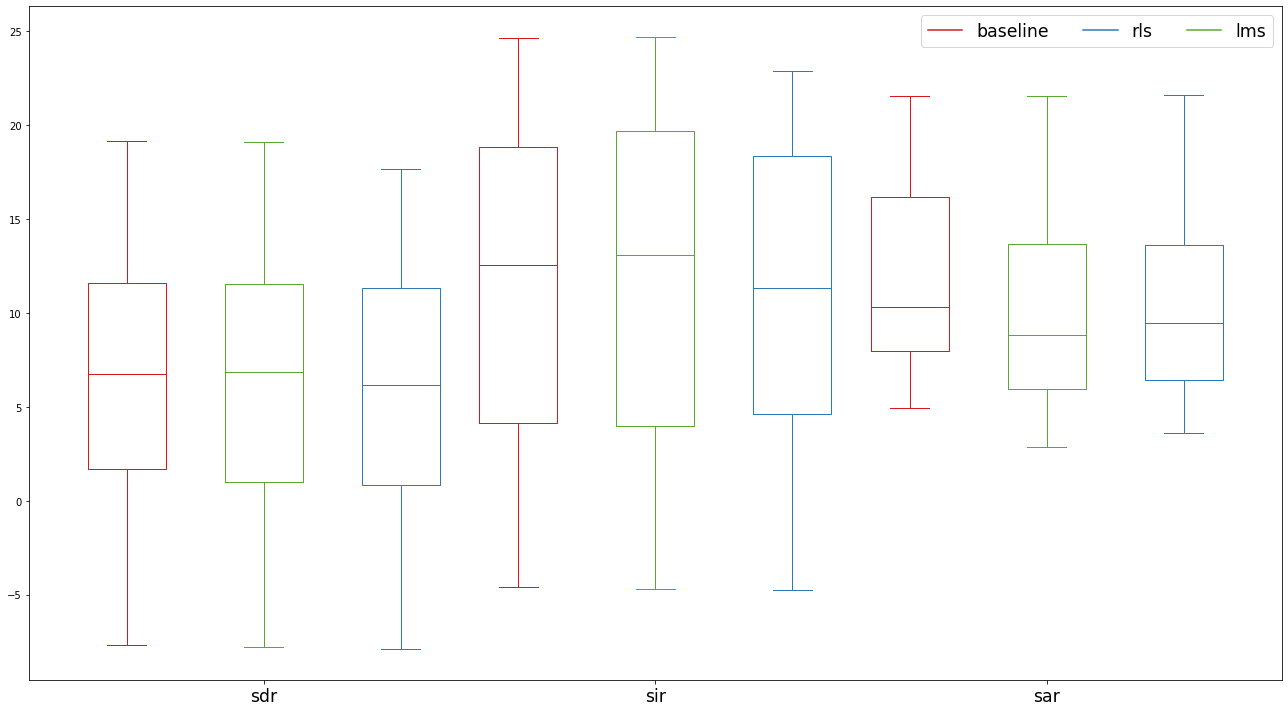

In [117]:
ticks = ['sdr', 'sir', 'sar']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (18,10))

bpl = plt.boxplot(df_bss.T, positions=np.array(range(len(df_bss.T)))*2.0-0.7, sym='', widths=0.4)
bpm = plt.boxplot(lms_performance_bss.T, positions=np.array(range(len(lms_performance_bss.T)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(rls_performance_bss.T, positions=np.array(range(len(rls_performance_bss.T)))*2.0+0.7, sym='', widths=0.4)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')
set_box_color(bpm, '#58a832')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='baseline')
plt.plot([], c='#2C7BB6', label='rls')
plt.plot([], c='#58a832', label = 'lms')
plt.legend(ncol = 3, fontsize = 'xx-large')

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 'xx-large')
#plt.xlim(-2, len(ticks)*3)
plt.tight_layout()
plt.savefig('resultsComparisonBSS.png')

In [119]:
df_anc_mse = df_anc[['mse']]
lms_performance_anc_mse = lms_performance_anc[['mse']]
rls_performance_anc_mse = rls_performance_anc[['mse']]

df_anc_snr = df_anc[['snr']]
lms_performance_anc_snr = lms_performance_anc[['snr']]
rls_performance_anc_snr = rls_performance_anc[['snr']]


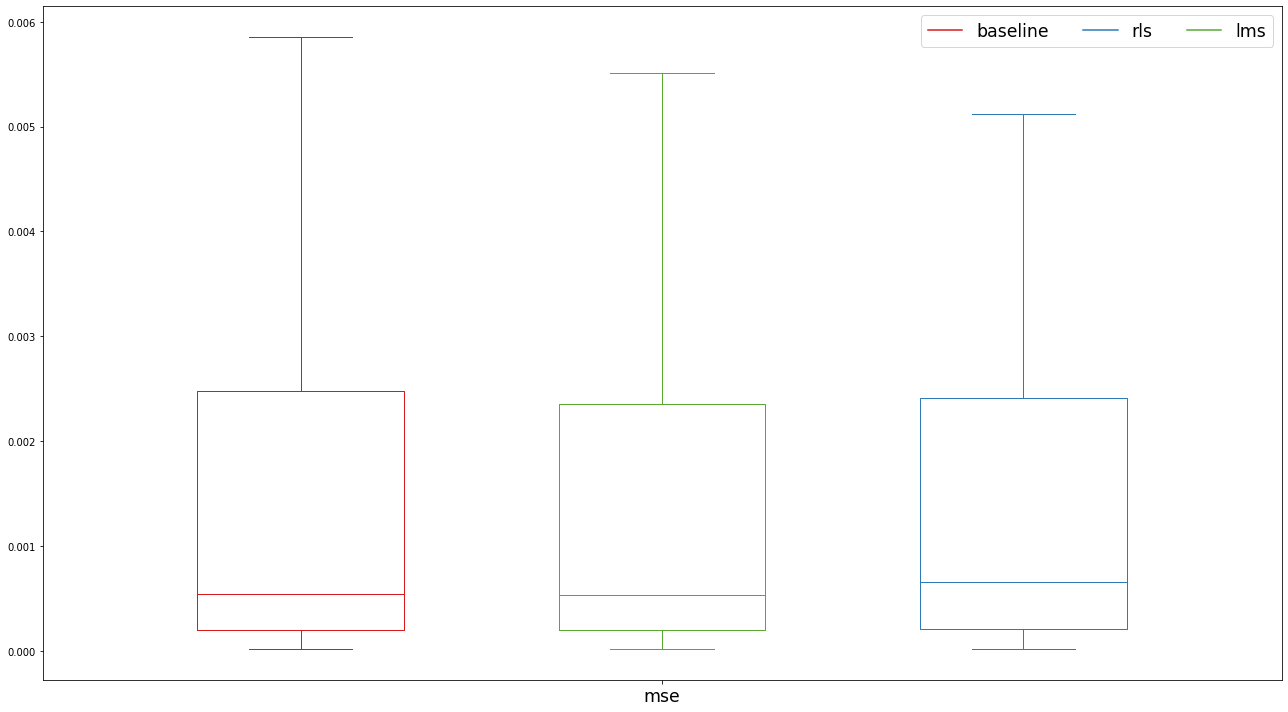

In [122]:
ticks = ['mse']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (18,10))

bpl = plt.boxplot(df_anc_mse.T, positions=np.array(range(len(df_anc_mse.T)))*2.0-0.7, sym='', widths=0.4)
bpm = plt.boxplot(lms_performance_anc_mse.T, positions=np.array(range(len(lms_performance_anc_mse.T)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(rls_performance_anc_mse.T, positions=np.array(range(len(rls_performance_anc_mse.T)))*2.0+0.7, sym='', widths=0.4)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')
set_box_color(bpm, '#58a832')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='baseline')
plt.plot([], c='#2C7BB6', label='rls')
plt.plot([], c='#58a832', label = 'lms')
plt.legend(ncol = 3, fontsize = 'xx-large')

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 'xx-large')
#plt.xlim(-2, len(ticks)*3)
plt.tight_layout()
plt.savefig('resultsComparisonANCmse.png')

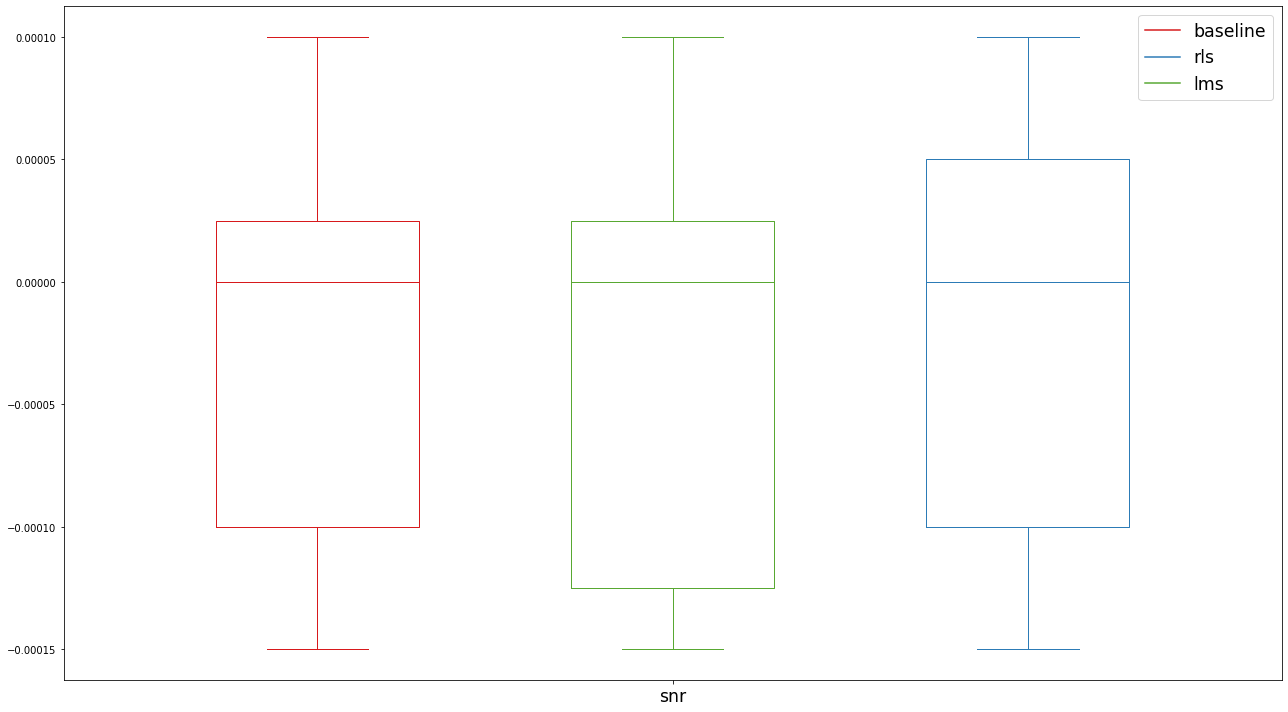

In [124]:
ticks = ['snr']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize = (18,10))

bpl = plt.boxplot(df_anc_snr.T, positions=np.array(range(len(df_anc_snr.T)))*2.0-0.7, sym='', widths=0.4)
bpm = plt.boxplot(lms_performance_anc_snr.T, positions=np.array(range(len(lms_performance_anc_snr.T)))*2.0, sym='', widths=0.4)
bpr = plt.boxplot(rls_performance_anc_snr.T, positions=np.array(range(len(rls_performance_anc_snr.T)))*2.0+0.7, sym='', widths=0.4)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')
set_box_color(bpm, '#58a832')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='baseline')
plt.plot([], c='#2C7BB6', label='rls')
plt.plot([], c='#58a832', label = 'lms')
plt.legend(loc = 'upper right', fontsize = 'xx-large')

plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize = 'xx-large')
#plt.xlim(-2, len(ticks)*3)
plt.tight_layout()
plt.savefig('resultsComparisonANCsnr.png')